In [165]:
# dataset : http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Bodyfat.html
%load_ext autoreload
%autoreload 1

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%aimport optim
%aimport losses
%aimport regularization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def preprocess_X(X_train, X_test):
    mean = np.mean(X_train,axis=0)
    std = np.std(X_train,axis=0)
    return (X_train-mean)/std, (X_test-mean)/std

def preprocess_y(y_train, y_test):
    mean = y_train.mean()
    return y_train-mean, y_test-mean

In [135]:
df = pd.read_csv('data/Bodyfat.csv')
X = df.drop('bodyfat', axis=1).values
y = df['bodyfat'].values[:,None]

n,p = X.shape
split = 0.2
train_indices = np.random.choice(np.arange(len(X)), int((1-split) * len(X)), replace = False)
test_indices = np.array(list(set(np.arange(len(X))).difference(set(train_indices))))

print(len(train_indices))
print(len(test_indices))
print(len(X))

X_train, X_test = preprocess_X(X[train_indices], X[test_indices])
y_train, y_test = preprocess_y(y[train_indices], y[test_indices])

print(type(X))
df.head()

201
51
252
<class 'numpy.ndarray'>


,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [137]:
def print_residuals(X,w,y):
    plt.plot(X@w, '.-')
    plt.plot(y, '.-')
    plt.show()

In [157]:
#  convert to a column vector
def MakeCol(y): return y.reshape(-1,1)
#  convert to a row vector
def MakeRow(y): return y.reshape(1,-1)
# find non zero/true elements
def find(x): return np.nonzero(x)[0]

from scipy import io
name = 'prostate';
U = io.loadmat('nt_toolbox/data/ml-' + name)
A = U['A']
class_names = U['class_names']

A = A[np.random.permutation(A.shape[0]),:]

X = A[:,0:-2];
y = MakeCol( A[:,-2] )
c = MakeCol( A[:,-1] )

[n,p] = X.shape
print(n,p)

I0 = find(c==1) # train
I1 = find(c==0) # test
n0 = I0.size
n1 = n-n0
X0 = X[I0,:]
y0 = y[I0]
X1 = X[I1,:]
y1 = y[I1]

mX0 = X0.mean(axis=0)
sX0 = X0.std(axis=0)
X_train = (X0-mX0)/sX0
X_test = (X1-mX0)/sX0

m0 = y0.mean()
y_train = y0-m0
y_test = y1-m0

97 8


## Simple Linear Regression

In [158]:
w = np.linalg.solve(X_train.T @ X_train, X_train.T @ y_train)
w

array([[ 0.71104059],
       [ 0.29045029],
       [-0.14148182],
       [ 0.21041951],
       [ 0.30730025],
       [-0.28684075],
       [-0.02075686],
       [ 0.27526843]])

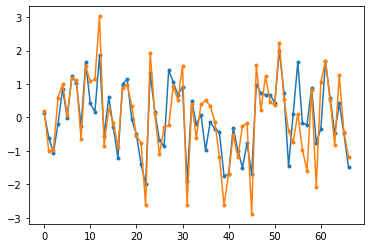

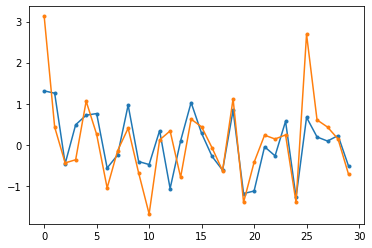

In [159]:
print_residuals(X_train,w,y_train)
print_residuals(X_test,w,y_test)

In [160]:
def mse(y_pred, y_true):
    return np.linalg.norm(y_true - y_pred)

def relative_mse(y_pred, y_true):
    return np.linalg.norm(y_true - y_pred)/np.linalg.norm(y_true)

print(mse(X_train@w, y_train))
print(mse(X_test@w, y_test))

print(relative_mse(X_train@w, y_train))
print(relative_mse(X_test@w, y_test))

5.424609152732425
3.95451895497139
0.5528370648963185
0.7023447693100114


## Ridge

In [88]:
%time
w = np.linalg.solve( X_train.T @ X_train + lbda * np.identity(p), X_train.T @ y_train)
w

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


array([-0.0176934 ,  0.0046695 ,  0.01104952, -0.00085101,  0.00871577,
        0.01241248,  0.01454796,  0.01113953,  0.01039861,  0.00943046,
        0.00483034,  0.00882033,  0.00678786,  0.00616465])

In [89]:
%time
u = np.linalg.solve( X_train @ X_train.T + lbda * np.identity(len(X_train)), y_train)
w2 = X_train.T @ u
w2

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs


array([-0.0176934 ,  0.0046695 ,  0.01104952, -0.00085101,  0.00871577,
        0.01241248,  0.01454796,  0.01113953,  0.01039861,  0.00943046,
        0.00483034,  0.00882033,  0.00678786,  0.00616465])

## Lasso

In [8]:
def J(X, y, w, lbda):
    return 1/2*np.linalg.norm(X.dot(w)-y)**2 + lbda*np.linalg.norm(w, 1)

# losses.leastSquare.func(X, y, w) + Regularization.lasso(x, lbda)

In [254]:
# take the operator norm of X
X_norm = losses.LeastSquare.L(X_train)
tau = 1.5/(X_norm**2)

lmax = abs( X_train.transpose().dot(y_train) ).max()
lbda = lmax /10

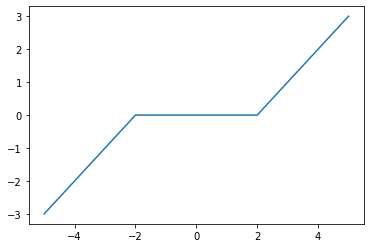

In [11]:
t = np.linspace(-5,5,201)
plt.clf
plt.plot(t,Soft(t,2)) 
plt.axis('tight');

In [255]:
iast = optim.IAST(losses.LeastSquare, 'lasso', lmax, lbda=lbda)

In [256]:
iast.multiple_steps(X_train, y_train, tau, n=200)
# iast.single_step(X_train, y_train, np.zeros((X_train.shape[1],1)), tau)

array([[ 0.572094  ],
       [ 0.23325178],
       [-0.        ],
       [ 0.11641371],
       [ 0.17945735],
       [-0.        ],
       [ 0.        ],
       [ 0.07265907]])

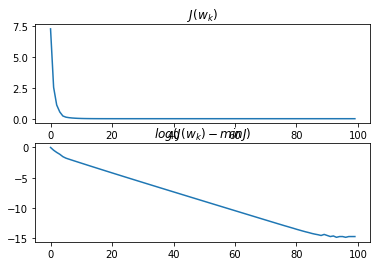

In [257]:
n_iter = 400
iast = optim.IAST(losses.LeastSquare, 'lasso', lmax, lbda=lbda)
iast.multiple_steps(X_train, y_train, tau, n=n_iter)

e=np.log10(iast.data['J'][:100]-np.min(iast.data['J']) +1e-20)

plt.clf
fig, ax = plt.subplots(2)
ax[0].set_title('$J(w_k)$')
ax[1].set_title('$log(J(w_k)-min J)$')

ax[0].plot(iast.data['J'][:100]-iast.data['J'][-1])
ax[1].plot(e-e[0])

ax[0].axis('tight')
ax[1].axis('tight')

plt.show()

In [275]:
n_iter = 400
q = 200
lbda_list = lmax*np.linspace(0.6,1e-3,q)

E_train = np.zeros(q)
E_test = np.zeros(q)
W = np.zeros((q,n_iter,p))


for i,lbda in enumerate(lbda_list):
    iast = optim.IAST(losses.LeastSquare, 'lasso', lmax, lbda=lbda)
    w = iast.multiple_steps(X_train, y_train, tau, n=n_iter)
    
    E_train[i] = iast.loss.loss(X_train,y_train,w)/np.linalg.norm(y_train)
    E_test[i] = iast.loss.loss(X_test,y_test,w)/np.linalg.norm(y_test)
    W[i] = iast.data['W']
    
# find optimal Lambda
i = E_test.argmin()
lambdaSparse = lbda_list[i]
wSparse = W[i,-1,:]
print( 'Lasso: ' + str(E_test.min()*100) + '%' )

Lasso: 120.49218305949377%


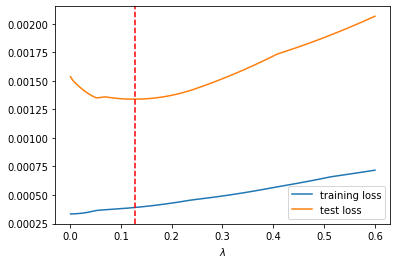

In [292]:
plt.clf
plt.plot(lbda_list/lmax, 1/len(X_train) * E_train/len(X_train), label='training loss')
plt.plot(lbda_list/lmax, 1/len(X_test) * E_test/len(X_test), label='test loss')
plt.axvline(lambda0/lmax, color='red', linestyle='--')
plt.xlabel('$\lambda/|X^* y|_\infty$')
plt.legend()
plt.show()

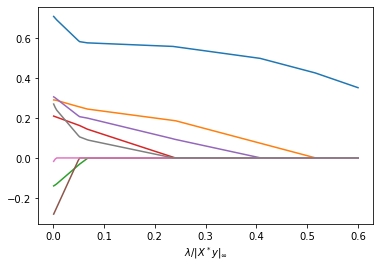

In [295]:
for k in range(p):
    plt.plot(lbda_list/lmax, W[:,-1,k])
plt.xlabel('$\lambda/|X^* y|_\infty$')
# plt.legend()
plt.show()

In [218]:
print(J(w,lbda))
print(iast.loss.loss(X_train,y_train,w)+iast.regul(w, iast.lbda))

23.658051753631096
23.658051753631096


In [217]:
def J(w,Lambda): return 1/2*np.linalg.norm(X_train.dot(w)-y_train)**2 + Lambda*np.linalg.norm(w,1)

In [213]:
def Soft(x,s): return np.maximum( abs(x)-s, np.zeros(x.shape)  ) * np.sign(x)
C = X_train.transpose().dot(X_train)
u = X_train.transpose().dot(y_train)
def ISTA(w,lbda,tau): return Soft( w-tau*( C.dot(w)-u ), lbda*tau )
w = np.zeros((p,1))
n_iter = 200
for i in range(n_iter):
    w = ISTA(w,lbda,tau)
w

array([[ 0.572094  ],
       [ 0.23325178],
       [-0.        ],
       [ 0.11641371],
       [ 0.17945735],
       [-0.        ],
       [ 0.        ],
       [ 0.07265907]])

### Check with scklearn

In [298]:
from sklearn.linear_model import Lasso, Ridge, LassoCV
from sklearn.metrics import mean_squared_error

In [302]:
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train.squeeze())
print(lasso.coef_)
print(lasso.alpha_)

[ 0.70802081  0.29017766 -0.13993456  0.20938804  0.30565984 -0.28109219
 -0.01702456  0.26956615]
0.0008788804136615378


In [305]:
wSparse

array([ 0.56925341,  0.22406346, -0.        ,  0.09371537,  0.16258018,
        0.        ,  0.        ,  0.05804608])

In [246]:
mean_squared_error(lasso.predict(X), y)

7.46114027017436